In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('mushrooms.csv')

# EDA. Anàlisi de les dades

Per començar a treballar amb les dades, hem d'analitzar quin tipus d'informació tenim. Utilitzarem el mètode info() per obtenir una visió general i verificar si existeixen o no valors nuls.

In [3]:
print("Informació general del dataset:")
data.info()

print("\nValors únics per cada columna:")
for col in data.columns:
    print(f"{col}: {data[col].unique()[:5]}... ({len(data[col].unique())} únics)")

Informació general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   obje

En primera instància observem que tenim 8124 entrades i 23 columnes (totes categòriques), on les quals no trobem cap indici que tinguin valors nuls. Tot i això, més endavant, afegirem alguns valors nuls aleatòriament per veure com varia el nostre model. També podem veure els diferents valors únics de cada columna per observar quantes categories hi ha per cada columna i tenir una idea de la diversitat de dades que hi ha. La nostra columna objectiu es "class" la qual conté dues classes: e (comestible) i p (verinós):

Porcentatge de les classes:
class
e    51.797144
p    48.202856
Name: proportion, dtype: float64


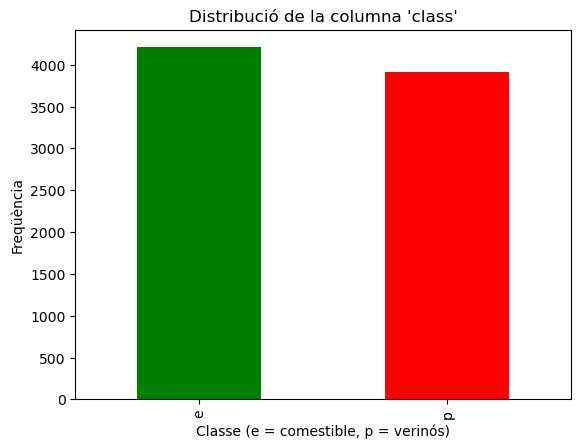

In [4]:
print("Porcentatge de les classes:")
print(data['class'].value_counts(normalize=True)*100)

data['class'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Distribució de la columna 'class'")
plt.xlabel("Classe (e = comestible, p = verinós)")
plt.ylabel("Freqüència")
plt.show()

El dataset està bastant balancejat, ja que les dues classes tenen una proporció molt semblant, així que no caldria cap mètode de balancejament.

# Preprocessing

Com s'ha observat anteriorment, en cap columna tenim valors nuls, però totes les columnes són categòriques, per tant, haurem de fer un tractament a aquestes columnes per poder-les codificar i així mirar les correlacions existents entre la columna objectiu 'class' i la resta:

In [5]:
codificacio = {}
data_codificada = data.copy()

for col in data.columns:
    le = LabelEncoder()
    data_codificada[col] = le.fit_transform(data[col])
    codificacio[col] = le

X = data_codificada.drop('class', axis=1)
y = data_codificada['class']

print("Dataset codificat:")
print(data_codificada)

Dataset codificat:
      class  cap-shape  cap-surface  cap-color  bruises  odor  \
0         1          5            2          4        1     6   
1         0          5            2          9        1     0   
2         0          0            2          8        1     3   
3         1          5            3          8        1     6   
4         0          5            2          3        0     5   
...     ...        ...          ...        ...      ...   ...   
8119      0          3            2          4        0     5   
8120      0          5            2          4        0     5   
8121      0          2            2          4        0     5   
8122      1          3            3          4        0     8   
8123      0          5            2          4        0     5   

      gill-attachment  gill-spacing  gill-size  gill-color  ...  \
0                   1             0          1           4  ...   
1                   1             0          0           4  ...   

S'ha utilitzats la codificació "ordinal encoding", que per cada valor únic que es troba a la columna, se li assigna un número enter. Ara anem a veure les diferents correlacions que trobem:

In [6]:
mutual_info = mutual_info_classif(X, y, discrete_features=True)
correlacions = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)
print("Correlacions entre 'class' i la resta de columnes: ")
print(correlacions)

Correlacions entre 'class' i la resta de columnes: 
odor                        0.628043
spore-print-color           0.333199
gill-color                  0.289027
ring-type                   0.220436
stalk-surface-above-ring    0.197357
stalk-surface-below-ring    0.188463
stalk-color-above-ring      0.175952
stalk-color-below-ring      0.167337
gill-size                   0.159531
population                  0.139987
bruises                     0.133347
habitat                     0.108709
stalk-root                  0.093448
gill-spacing                0.069927
cap-shape                   0.033823
ring-number                 0.026653
cap-color                   0.024987
cap-surface                 0.019817
veil-color                  0.016509
gill-attachment             0.009818
stalk-shape                 0.005210
veil-type                   0.000000
dtype: float64


Per veure-ho de manera més clara:

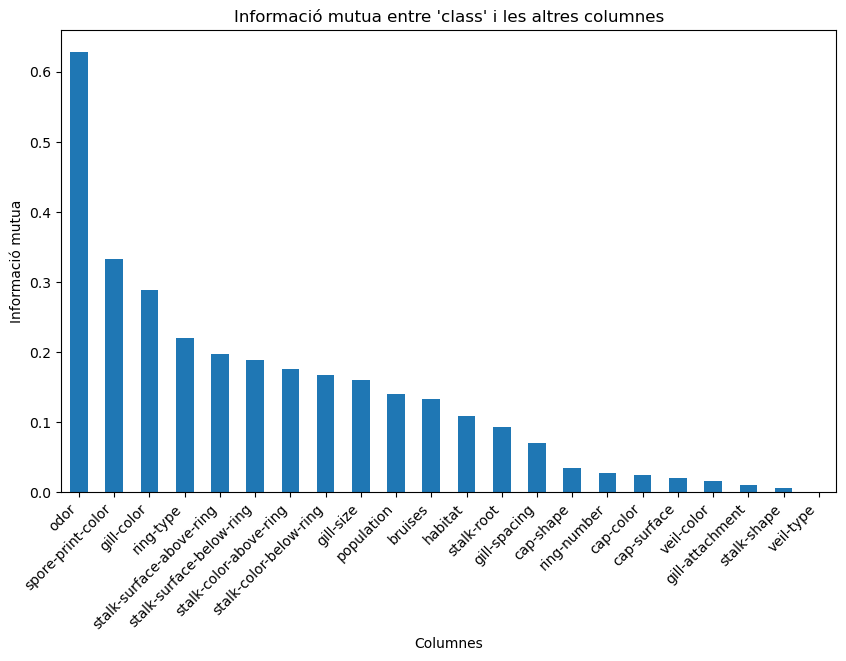

In [7]:
plt.figure(figsize=(10,6))
correlacions.plot(kind='bar')
plt.title("Informació mutua entre 'class' i les altres columnes")
plt.xlabel("Columnes")
plt.ylabel("Informació mutua")
plt.xticks(rotation=45, ha='right')
plt.show()

La columna odor és la columna que més informació ens dona per determinar la classe de bolet, ja que té una forta dependència i ens diu que la olor por determinar bastant si el bolet es pot menjar o no. El color de les espores, de les brànquies o la superfície del peu del bolet també ens dona bastanta informació (no tant com la olor). 